# Supervised Learning with CatBoost
This notebook demonstrates the use of the CatBoost classifier for supervised learning, including data preprocessing, model training, cross-validation, and evaluation.

In [1]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, matthews_corrcoef
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np

# Data Preprocessing
This section preprocesses the training and testing datasets by removing missing values and separating features and target variables.

In [2]:
# Run the dataInfo notebook to preprocess the data
%run dataInfo.ipynb

# Load the train and test datasets
train_df = train_df.dropna() 
test_df = test_df.dropna()  

# Preprocess the train dataset
X = train_df.drop(columns=['Class/ASD'])
y = train_df['Class/ASD']

# Apply SMOTE and Define Model
This section applies SMOTE to balance the dataset and defines the CatBoost model and cross-validation strategy.

In [3]:
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Define the CatBoost model
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

# Define stratified 10-fold CV with 3 repeats
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Initialize Metrics
This section initializes lists to store evaluation metrics and precision-recall data.

In [ ]:
# Initialize lists to store metrics
roc_auc_scores = []
pr_auc_scores = []
f1_scores = []
mcc_scores = []

# Initialize Lists for cross-validation
all_precision = []
all_recall = []
PR_curve_list = []

# Perform Cross-Validation
This section performs cross-validation, trains the model, and calculates evaluation metrics for each fold.

In [12]:
for train_idx, val_idx in cv.split(X_resampled, y_resampled):
    X_train, X_val = X_resampled.iloc[train_idx], X_resampled.iloc[val_idx]
    y_train, y_val = y_resampled.iloc[train_idx], y_resampled.iloc[val_idx]

    # Train the model
    catboost_model.fit(X_train, y_train)

    # Make predictions
    y_val_pred = catboost_model.predict(X_val)
    y_val_pred_proba = catboost_model.predict_proba(X_val)[:, 1]

    # Calculate metrics
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
    pr_auc = np.trapezoid(recall, precision)
    f1 = f1_score(y_val, y_val_pred)
    mcc = matthews_corrcoef(y_val, y_val_pred)

    # Append metrics to lists
    roc_auc_scores.append(roc_auc)
    pr_auc_scores.append(pr_auc)
    f1_scores.append(f1)
    mcc_scores.append(mcc)

    # Store precision and recall for aggregation
    all_precision.append(precision)
    all_recall.append(recall)
    PR_curve_list.append((precision, recall))


# Aggregate Metrics and Calculate Confidence Intervals
This section aggregates precision-recall curves and calculates confidence intervals for evaluation metrics.

In [18]:
# Aggregate precision-recall curves
mean_precision = np.linspace(0, 1, 100)
mean_recall = np.zeros_like(mean_precision)

for precision, recall in zip(all_precision, all_recall):
    mean_recall += np.interp(mean_precision, np.flip(recall), np.flip(precision))
mean_recall /= len(all_precision)

# Calculate the area under the aggregated curve
pr_auc = auc(mean_precision, mean_recall)

# Calculate mean and confidence intervals for each metric
def calculate_ci(scores):
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    ci_lower = mean_score - 1.96 * std_score / np.sqrt(len(scores))
    ci_upper = mean_score + 1.96 * std_score / np.sqrt(len(scores))
    return mean_score, ci_lower, ci_upper

mean_roc_auc, ci_lower_roc_auc, ci_upper_roc_auc = calculate_ci(roc_auc_scores)
mean_pr_auc, ci_lower_pr_auc, ci_upper_pr_auc = calculate_ci(pr_auc_scores)
mean_f1, ci_lower_f1, ci_upper_f1 = calculate_ci(f1_scores)
mean_mcc, ci_lower_mcc, ci_upper_mcc = calculate_ci(mcc_scores)

# Visualize Results and Summary
This section visualizes the precision-recall curves and prints the summary of evaluation metrics.

Mean ROC-AUC: 0.9720930472883598 (95% CI: 0.9672614301347551, 0.9769246644419645)
Mean PR-AUC: 0.4671730691414756 (95% CI: 0.46051606829620356, 0.47383006998674765)
Mean F1 Score: 0.9185654200258261 (95% CI: 0.9098000968595783, 0.9273307431920739)
Mean Matthews Correlation Coefficient: 0.8342036238630663 (95% CI: 0.8160131601249783, 0.8523940876011544)


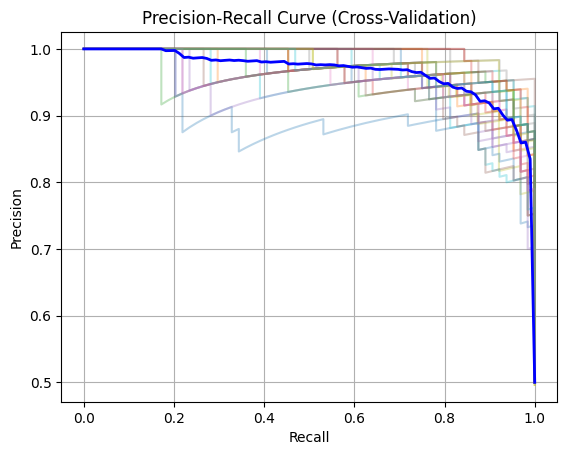

In [22]:
# Print results
for i, (precision, recall) in enumerate(PR_curve_list):
    plt.plot(recall, precision, alpha=0.3, label=f'Fold {i+1} PR Curve')
# Plot the aggregated curve
plt.plot(mean_precision, mean_recall, color='blue', lw=2, label=f'Average PR Curve (AUC = {pr_auc:.2f})')
# Add labels and legend
plt.title('Precision-Recall Curve (Cross-Validation)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

print(f"Mean ROC-AUC: {mean_roc_auc} (95% CI: {ci_lower_roc_auc}, {ci_upper_roc_auc})")
print(f"Mean PR-AUC: {mean_pr_auc} (95% CI: {ci_lower_pr_auc}, {ci_upper_pr_auc})")
print(f"Mean F1 Score: {mean_f1} (95% CI: {ci_lower_f1}, {ci_upper_f1})")
print(f"Mean Matthews Correlation Coefficient: {mean_mcc} (95% CI: {ci_lower_mcc}, {ci_upper_mcc})")